In [1]:
#---import packages

rm(list = ls())
library(glmnet)
library(tidyverse)
library(tidytext)
library(ggplot2)
options(digits = 2)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ tidyr::expand()     masks Matrix::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::when()       masks foreach::when()


In [2]:
#---Reading data

dat <- read.csv("/Users/tete/628data/bus_pizza.csv", header = T)
sum(dat$name == "Pizza Hut")
sum(dat$name == "Domino's Pizza")
sum(dat$name == "Papa John's Pizza")

[1] 247

[1] 152

[1] 119

In [3]:
#---Selecting 3 companies

id_hut <- dat$business_id[dat$name == "Pizza Hut"]
id_domino <- dat$business_id[dat$name == "Domino's Pizza"]
id_john <- dat$business_id[dat$name == "Papa John's Pizza"]

review <- read.csv("/Users/tete/628data/review_pizza.csv", header = T)

hut <- review[review$business_id %in% id_hut, ]
domino <- review[review$business_id %in% id_domino, ]
john <- review[review$business_id %in% id_john, ]

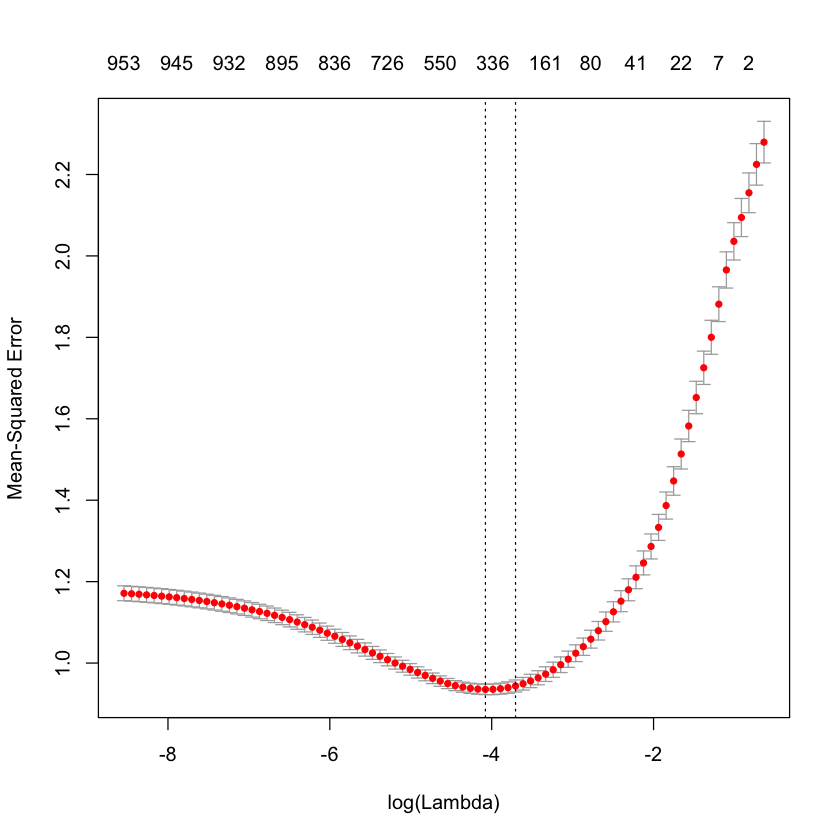

In [4]:
#---Pizza Hut

df <- data.frame(text = hut$text, index = 1:nrow(hut))
df$text <- as.character(df$text)
words <- df %>% unnest_tokens(word, text)
sparse <- cast_sparse(words, index, word)
amount <- colSums(sparse)
X <- sparse[, amount > 30]
amount <- colSums(X)
X <- X[, amount < nrow(df)/2]
Y <- as.numeric(hut$stars)
cvfit <- cv.glmnet(X, Y)
plot(cvfit)
model <- glmnet(X, Y, lambda = cvfit$lambda.min)
beta <- data.frame(word = row.names(as.matrix(model$beta)), beta = as.numeric(model$beta))
hut_word <- head(beta[sort(beta$beta,index.return=TRUE)$ix,], n = 20)

write.csv(hut_word, '/Users/tete/Desktop/Pizza_Hut.csv', row.names = F)

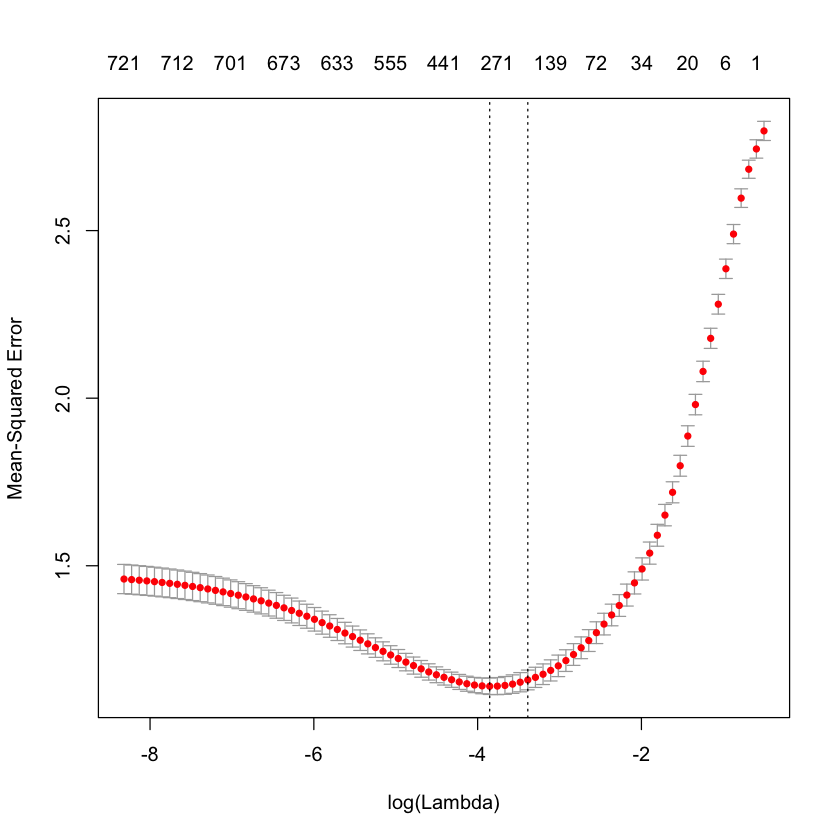

In [5]:
#---Domino

df <- data.frame(text = domino$text, index = 1:nrow(domino))
df$text <- as.character(df$text)
words <- df %>% unnest_tokens(word, text)
sparse <- cast_sparse(words, index, word)
amount <- colSums(sparse)
X <- sparse[, amount > 30]
amount <- colSums(X)
X <- X[, amount < nrow(df)/2]
Y <- as.numeric(domino$stars)
cvfit <- cv.glmnet(X, Y)
plot(cvfit)
model <- glmnet(X, Y, lambda = cvfit$lambda.min)
beta <- data.frame(word = row.names(as.matrix(model$beta)), beta = as.numeric(model$beta))
domino_word <- head(beta[sort(beta$beta,index.return=TRUE)$ix,], n = 20)

write.csv(domino_word, '/Users/tete/Desktop/Domino.csv', row.names = F)

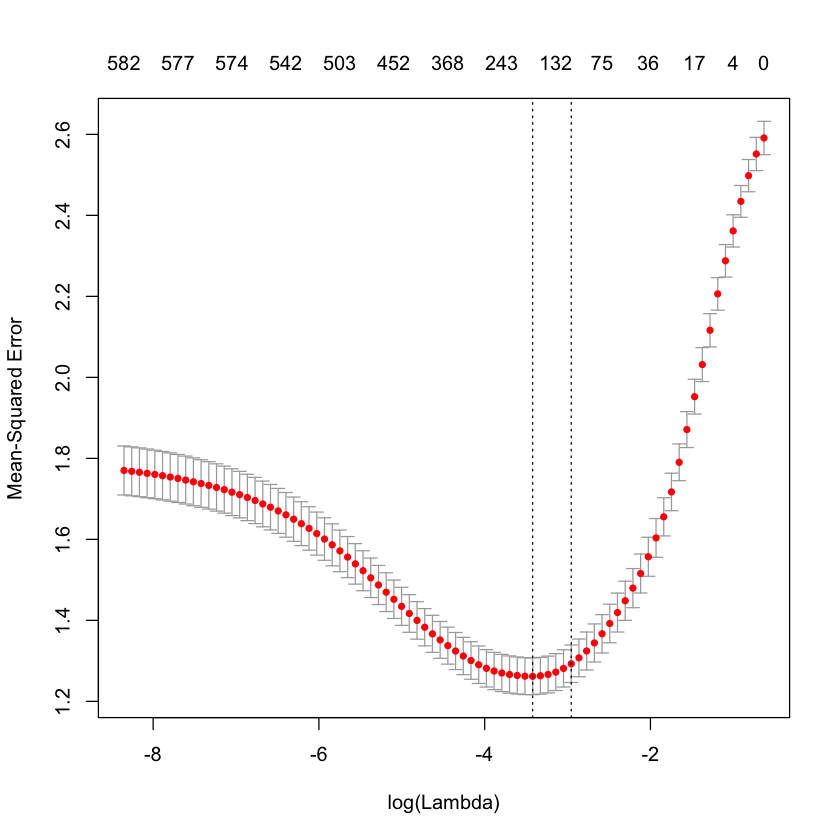

In [6]:
#---Papa John

df <- data.frame(text = john$text, index = 1:nrow(john))
df$text <- as.character(df$text)
words <- df %>% unnest_tokens(word, text)
sparse <- cast_sparse(words, index, word)
amount <- colSums(sparse)
X <- sparse[, amount > 30]
amount <- colSums(X)
X <- X[, amount < nrow(df)/2]
Y <- as.numeric(john$stars)
cvfit <- cv.glmnet(X, Y)
plot(cvfit)
model <- glmnet(X, Y, lambda = cvfit$lambda.min)
beta <- data.frame(word = row.names(as.matrix(model$beta)), beta = as.numeric(model$beta))
john_word <- head(beta[sort(beta$beta,index.return = TRUE)$ix,], n = 20)


write.csv(john_word, '/Users/tete/Desktop/Papa_John.csv', row.names = F)

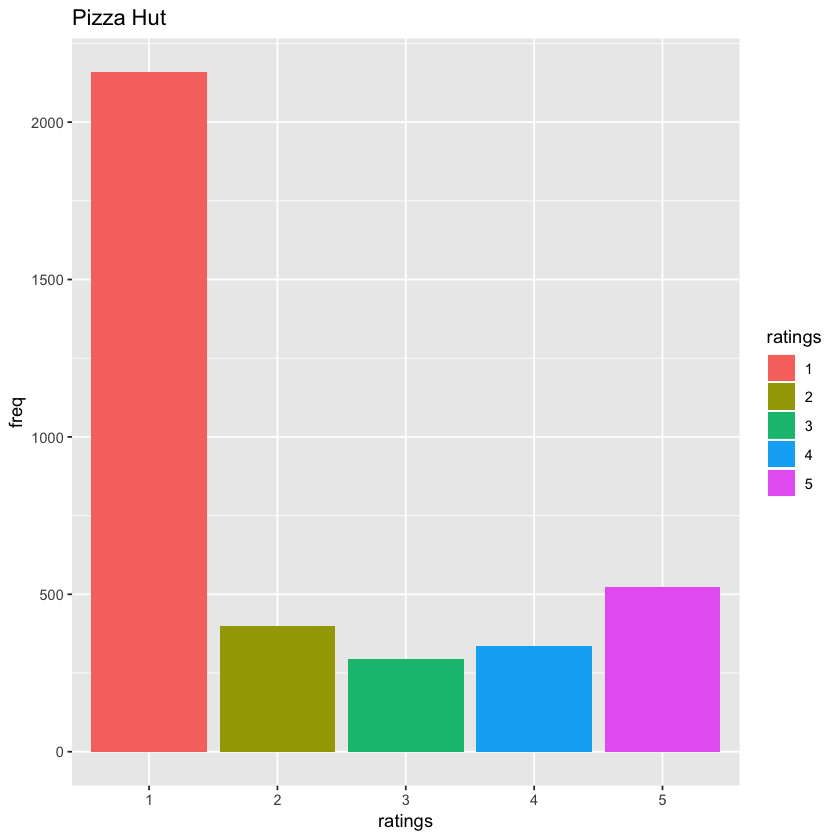

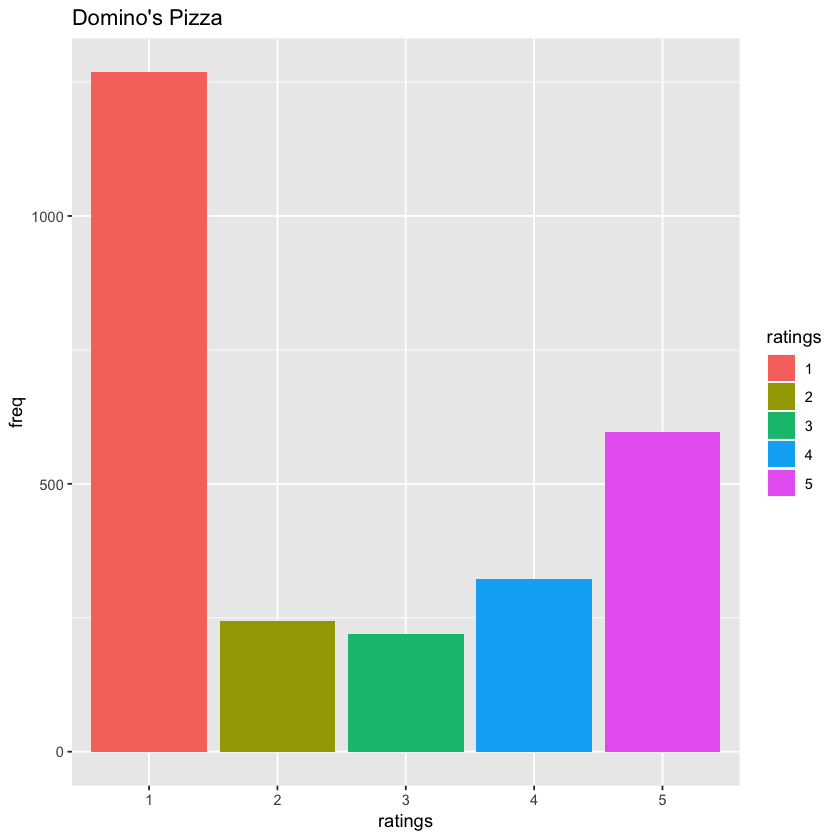

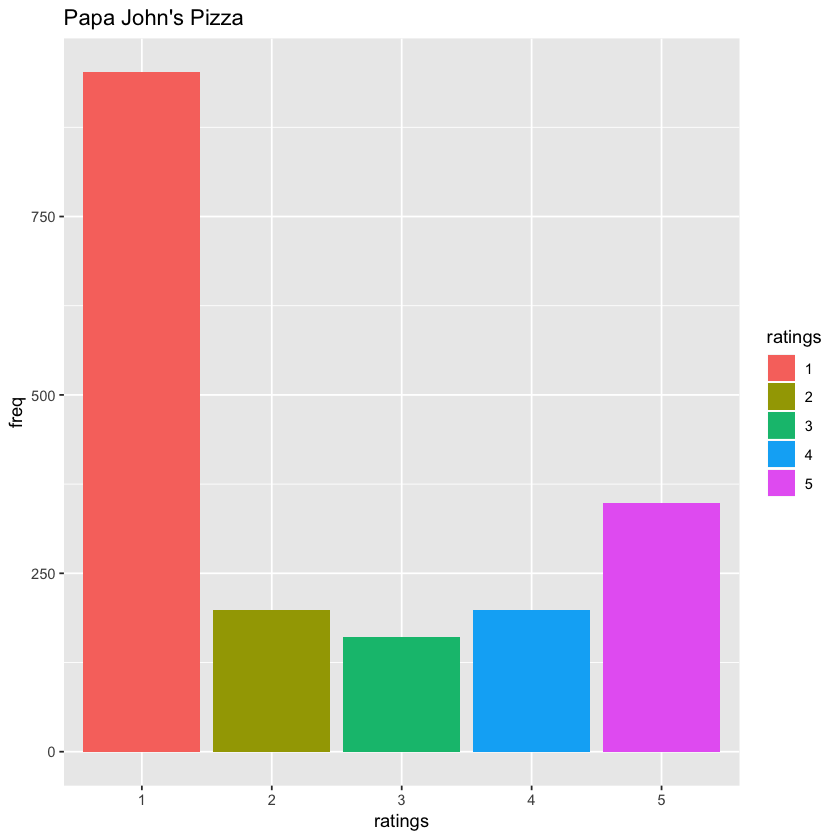

In [7]:
#---Comparing Stars

hut_plot <- data.frame(ratings = as.character(1:5), freq = as.numeric(table(hut$stars)))
ggplot(data = hut_plot, mapping = aes(x = ratings, y = freq, fill = ratings, group = factor(1))) + 
  geom_bar(stat="identity") + ggtitle('Pizza Hut')

domino_plot <- data.frame(ratings = as.character(1:5), freq = as.numeric(table(domino$stars)))
ggplot(data = domino_plot, mapping = aes(x = ratings, y = freq, fill = ratings, group = factor(1))) + 
  geom_bar(stat="identity") + ggtitle('Domino\'s Pizza')

john_plot <- data.frame(ratings = as.character(1:5), freq = as.numeric(table(john$stars)))
ggplot(data = john_plot, mapping = aes(x = ratings, y = freq, fill = ratings, group = factor(1))) + 
  geom_bar(stat="identity") + ggtitle('Papa John\'s Pizza')

In [8]:
#---Permutation Test

mean.diff <- function(X, index){
  return(mean(X[index == 1]) - mean(X[index == 2]))
}

n1 <- nrow(domino); n2 <- nrow(hut); n <- n1 + n2
X <- c(as.numeric(domino$stars), as.numeric(hut$stars))
index <- c(rep(1, n1), rep(2, n2))
Dobs <- mean.diff(X, index)
results <- replicate(9999, mean.diff(sample(X), index))
p.value <- length(results[results > Dobs])/10000
cat('The p-value of H0: Domino < Pizza Hut is', p.value, '\n')

n1 <- nrow(john); n2 <- nrow(hut); n <- n1 + n2
X <- c(as.numeric(john$stars), as.numeric(hut$stars))
index <- c(rep(1, n1), rep(2, n2))
Dobs <- mean.diff(X, index)
results <- replicate(9999, mean.diff(sample(X), index))
p.value <- length(results[results > Dobs])/10000
cat('The p-value of H0: Papa John < Pizza Hut is', p.value, '\n')

n1 <- nrow(domino); n2 <- nrow(john); n <- n1 + n2
X <- c(as.numeric(domino$stars), as.numeric(john$stars))
index <- c(rep(1, n1), rep(2, n2))
Dobs <- mean.diff(X, index)
results <- replicate(9999, mean.diff(sample(X), index))
p.value <- length(results[results > Dobs])/10000
cat('The p-value of H0: Domino < Papa John is', p.value, '\n')

The p-value of H0: Domino < Pizza Hut is 0 
The p-value of H0: Papa John < Pizza Hut is 0 
The p-value of H0: Domino < Papa John is 4e-04 
